##Загрузка данных


In [8]:
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv('https://raw.githubusercontent.com/MakarovaJulia/ap_dataset/main/retail_dataset.csv')

In [10]:
data.head(10)

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN
5,Eggs,Bread,Wine,Pencil,Milk,Diaper,Bagel
6,Wine,Pencil,Eggs,Cheese,NaN,NaN,NaN
7,Bagel,Bread,Milk,Pencil,Diaper,NaN,NaN
8,Bread,Diaper,Cheese,Milk,Wine,Eggs,NaN
9,Bagel,Wine,Diaper,Meat,Pencil,Eggs,Cheese


In [11]:
data.shape

(315, 7)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       315 non-null    object
 1   1       285 non-null    object
 2   2       245 non-null    object
 3   3       187 non-null    object
 4   4       133 non-null    object
 5   5       71 non-null     object
 6   6       41 non-null     object
dtypes: object(7)
memory usage: 17.4+ KB


In [13]:
data.describe()

,0,1,2,3,4,5,6
count,315,285,245,187,133,71,41
unique,9,9,9,9,9,9,9
top,Bread,Meat,Eggs,Milk,Wine,Pencil,Bread
freq,74,47,52,45,36,13,11


##Анализ датасета

Выведем топ 10 самых часто встречающихся товаров

In [14]:
# 1. Соберем все элементы каждой транзакции в массив Numpy
transaction = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        transaction.append(data.values[i,j])

transaction = np.array(transaction)

# 2. Преобразуем в Pandas DataFrame
df = pd.DataFrame(transaction, columns=["items"]) 
df["incident_count"] = 1 # Put 1 to Each Item For Making Countable Table, to be able to perform Group By

# 3. Удалим NaN Items
indexNames = df[df['items'] == "nan"].index
df.drop(indexNames , inplace=True)

# 4.Заключительный шаг: создадим новый Pandas DataFrame для визуализации
df_table = df.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()

df_table.head(10).style.background_gradient(cmap='Blues')

,items,incident_count
0,Bread,159
1,Cheese,158
2,Milk,158
3,Meat,150
4,Eggs,138
5,Wine,138
6,Bagel,134
7,Diaper,128
8,Pencil,114


Видим, что на первом месте стоит хлеб, ему незначительно уступают молоко и сыр

#Алгоритмы

##Apriory (mlxtend)

###One hot encoding

In [15]:
items = (data['0'].unique())
items

array(['Bread', 'Cheese', 'Meat', 'Eggs', 'Wine', 'Bagel', 'Pencil',
       'Diaper', 'Milk'], dtype=object)

In [16]:
encoded_vals = []
for index, row in data.iterrows(): 
    labels = {}
    uncommons = list(set(items) - set(row))
    commons = list(set(items).intersection(row))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)

In [17]:
dataset = pd.DataFrame(encoded_vals)

In [18]:
dataset

,Milk,Bagel,Cheese,Eggs,Meat,Wine,Diaper,Pencil,Bread
0,0,0,1,1,1,1,1,1,1
1,1,0,1,0,1,1,1,1,1
2,1,0,1,1,1,1,0,0,0
3,1,0,1,1,1,1,0,0,0
4,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
310,0,0,1,1,0,0,0,0,1
311,1,0,0,0,1,0,0,1,0
312,0,0,1,1,1,1,1,1,1
313,0,0,1,0,1,0,0,0,0


Теперь датасет представляет собой разреженную матрицу со значениями {1,0}.


Простой алгоритм Apriori состоит из трех шагов:

1.   Объединение. Просмотр базы данных и определение частоты вхождения отдельных товаров
2.   Отсечение. Те наборы, которые удовлетворяют поддержке и достоверности, переходят на следующую итерацию с двухкомпонентными наборами
3.   Повторение. Предыдущие два шага повторяются для каждой величины набора, пока не будет повторно получен ранее определенный размер



###Реализация

In [19]:
from mlxtend.frequent_patterns import apriori, association_rules

In [20]:
import time 

In [21]:
%%time
frequent_itemsets = apriori(dataset, min_support=0.01, use_colnames=True)

CPU times: user 25.9 ms, sys: 0 ns, total: 25.9 ms
Wall time: 32.2 ms


Выведем значение support для каждого набора

In [22]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.501587,(Milk),1
1,0.425397,(Bagel),1
2,0.501587,(Cheese),1
3,0.438095,(Eggs),1
4,0.476190,(Meat),1
...,...,...,...
417,0.025397,"(Cheese, Eggs, Meat, Wine, Pencil, Bread)",6
418,0.015873,"(Cheese, Eggs, Wine, Diaper, Pencil, Bread)",6
419,0.025397,"(Cheese, Meat, Wine, Diaper, Pencil, Bread)",6
420,0.015873,"(Eggs, Cheese, Meat, Wine, Pencil, Bread, Milk)",7


Теперь используем frequent_itemsets для создания ассоциативных правил.

Мы устанавливаем нашу метрику как "lift", чтобы определить, являются ли условия и следствия зависимыми или нет.

Пороговое значение выбрано как 1.2, поскольку при наличии зависимости требуется, чтобы значения lift были выше 1.

In [23]:
%%time
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

CPU times: user 36.1 ms, sys: 885 µs, total: 37 ms
Wall time: 39.5 ms


In [24]:
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
4543,"(Meat, Eggs, Pencil, Diaper)","(Wine, Cheese, Bagel)",0.034921,0.107937,0.012698,0.363636,3.368984,0.008929,1.401814,4,3
4566,"(Wine, Cheese, Bagel)","(Meat, Eggs, Pencil, Diaper)",0.107937,0.034921,0.012698,0.117647,3.368984,0.008929,1.093757,3,4
4502,"(Cheese, Eggs, Meat, Diaper, Pencil)","(Wine, Bagel)",0.022222,0.171429,0.012698,0.571429,3.333333,0.008889,1.933333,5,2
4607,"(Wine, Bagel)","(Cheese, Eggs, Meat, Diaper, Pencil)",0.171429,0.022222,0.012698,0.074074,3.333333,0.008889,1.056000,2,5
4576,"(Wine, Eggs, Bagel)","(Meat, Cheese, Pencil, Diaper)",0.092063,0.044444,0.012698,0.137931,3.103448,0.008607,1.108444,3,4
...,...,...,...,...,...,...,...,...,...,...,...
2982,(Meat),"(Eggs, Wine, Diaper, Milk, Bagel)",0.476190,0.022222,0.012698,0.026667,1.200000,0.002116,1.004566,1,5
3050,"(Eggs, Diaper, Bread, Milk, Bagel)",(Meat),0.022222,0.476190,0.012698,0.571429,1.200000,0.002116,1.222222,5,1
238,(Meat),"(Cheese, Milk, Bagel)",0.476190,0.088889,0.050794,0.106667,1.200000,0.008466,1.019900,1,3
3087,(Meat),"(Eggs, Diaper, Bread, Milk, Bagel)",0.476190,0.022222,0.012698,0.026667,1.200000,0.002116,1.004566,1,5


Отсортируем значения по достоверности

In [25]:
rules.sort_values("confidence",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
2789,"(Eggs, Cheese, Diaper, Milk, Bagel)",(Wine),0.012698,0.438095,0.012698,1.000000,2.282609,0.007135,inf,5,1
4158,"(Cheese, Eggs, Meat, Diaper, Pencil)",(Wine),0.022222,0.438095,0.022222,1.000000,2.282609,0.012487,inf,5,1
4498,"(Eggs, Meat, Wine, Diaper, Pencil, Bagel)",(Cheese),0.012698,0.501587,0.012698,1.000000,1.993671,0.006329,inf,6,1
4495,"(Cheese, Eggs, Meat, Diaper, Pencil, Bagel)",(Wine),0.012698,0.438095,0.012698,1.000000,2.282609,0.007135,inf,6,1
3886,"(Cheese, Eggs, Diaper, Pencil, Bagel)",(Wine),0.019048,0.438095,0.019048,1.000000,2.282609,0.010703,inf,5,1
...,...,...,...,...,...,...,...,...,...,...,...
2913,(Bread),"(Cheese, Meat, Diaper, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
3089,(Bread),"(Eggs, Meat, Diaper, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
3296,(Bread),"(Meat, Wine, Pencil, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
3639,(Bread),"(Eggs, Meat, Wine, Diaper, Milk)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5


Видим, что при большом количестве товаров в корзине, покупатель скорее всего купит и вино

Чтобы получить больше информации, можно создать таблицу достоверности, исключающую этот товар

In [26]:
rules[~rules["consequents"].str.contains("Wine", regex=False) & 
      ~rules["antecedents"].str.contains("Wine", regex=False)].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
1872,"(Meat, Milk, Pencil, Diaper)",(Bread),0.025397,0.504762,0.022222,0.875000,1.733491,0.009403,3.961905,4,1
3385,"(Eggs, Cheese, Meat, Pencil, Milk)",(Bread),0.025397,0.504762,0.022222,0.875000,1.733491,0.009403,3.961905,5,1
296,"(Meat, Eggs, Milk)",(Cheese),0.177778,0.501587,0.152381,0.857143,1.708861,0.063210,3.488889,3,1
468,"(Meat, Milk, Diaper)",(Bread),0.063492,0.504762,0.053968,0.850000,1.683962,0.021920,3.301587,3,1
1596,"(Meat, Cheese, Milk, Diaper)",(Bread),0.041270,0.504762,0.034921,0.846154,1.676343,0.014089,3.219048,4,1
1741,"(Meat, Eggs, Milk, Pencil)",(Bread),0.041270,0.504762,0.034921,0.846154,1.676343,0.014089,3.219048,4,1
3090,"(Eggs, Meat, Pencil, Bread, Bagel)",(Milk),0.019048,0.501587,0.015873,0.833333,1.661392,0.006319,2.990476,5,1
33,"(Meat, Milk)",(Cheese),0.244444,0.501587,0.203175,0.831169,1.657077,0.080564,2.952137,2,1
1298,"(Eggs, Milk, Pencil, Bagel)",(Bread),0.034921,0.504762,0.028571,0.818182,1.620926,0.010945,2.723810,4,1
1523,"(Eggs, Milk, Pencil, Cheese)",(Bread),0.050794,0.504762,0.041270,0.812500,1.609670,0.015631,2.641270,4,1


Видим, что есть связь между покупкой таких наборов как (Pencil, Meat, Milk, Diaper),(Cheese, Pencil, Meat, Eggs, Milk), (Meat, Milk, Diaper)	и покупкой хлеба

Посмотрим также на наборы товаров, состоящие из одного элемента

In [27]:
rules[(rules['antecedents_length'] == 1) & (rules['consequents_length'] == 1)].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
5,(Eggs),(Cheese),0.438095,0.501587,0.298413,0.681159,1.358008,0.078670,1.563203,1,1
6,(Meat),(Cheese),0.476190,0.501587,0.323810,0.680000,1.355696,0.084958,1.557540,1,1
2,(Bagel),(Bread),0.425397,0.504762,0.279365,0.656716,1.301042,0.064641,1.442650,1,1
7,(Cheese),(Meat),0.501587,0.476190,0.323810,0.645570,1.355696,0.084958,1.477891,1,1
8,(Wine),(Cheese),0.438095,0.501587,0.269841,0.615942,1.227986,0.050098,1.297754,1,1
11,(Eggs),(Meat),0.438095,0.476190,0.266667,0.608696,1.278261,0.058050,1.338624,1,1
0,(Cheese),(Milk),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148,1,1
1,(Milk),(Cheese),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148,1,1
4,(Cheese),(Eggs),0.501587,0.438095,0.298413,0.594937,1.358008,0.078670,1.387202,1,1
17,(Diaper),(Wine),0.406349,0.438095,0.234921,0.578125,1.319633,0.056901,1.331922,1,1


Видим, что есть связь между покупкой яиц и покупкой сыра, мяса и сыра, баранок и хлеба и т.д. Данные правила довольно часто (около 65%) срабатывают для датасета.

Попробуем использовать другую реализацию алгоритма apriory - Apyori.

##Apriory (apyori)

In [28]:
data.fillna(method = 'ffill',axis = 1, inplace = True)

In [29]:
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5973 sha256=ecb2545485ee1077154ae6a1042f2f672a1ae578a1bcac214fca187b6c9e4ff8
  Stored in directory: /root/.cache/pip/wheels/1b/02/6c/a45230be8603bd95c0a51cd2b289aefdd860c1a100eab73661
Successfully built apyori


In [30]:
import apyori
from apyori import apriori

In [31]:
transactions = []
for i in range(0, len(data)):
    transactions.append([str(data.values[i,j]) for j in range(1,4)])

In [32]:
%%time
rules = list(apriori(transactions, min_support = 0.01, min_confidence = 0.2, min_lift = 1.1, min_length = 2))

CPU times: user 3.08 ms, sys: 0 ns, total: 3.08 ms
Wall time: 3.1 ms


In [33]:
import shutil, os

In [34]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [35]:
import json

In [36]:
output = []
for RelationRecord in rules:
    o = StringIO()
    apyori.dump_as_json(RelationRecord, o)
    output.append(json.loads(o.getvalue()))
data_df = pd.DataFrame(output)

In [37]:
data_df.sort_values("support",ascending=False)

,items,support,ordered_statistics
0,"[Eggs, Meat]",0.149206,"[{'items_base': ['Eggs'], 'items_add': ['Meat'..."
1,"[Eggs, Milk]",0.139683,"[{'items_base': ['Eggs'], 'items_add': ['Milk'..."
2,"[Meat, Milk]",0.136508,"[{'items_base': ['Meat'], 'items_add': ['Milk'..."
15,"[Eggs, Meat, Milk]",0.104762,"[{'items_base': ['Eggs'], 'items_add': ['Meat'..."
11,"[Cheese, Milk, Wine]",0.019048,"[{'items_base': ['Milk', 'Wine'], 'items_add':..."
6,"[Bagel, Diaper, Pencil]",0.015873,"[{'items_base': ['Bagel', 'Diaper'], 'items_ad..."
9,"[Cheese, Diaper, Milk]",0.015873,"[{'items_base': ['Diaper', 'Milk'], 'items_add..."
14,"[Diaper, Milk, Pencil]",0.015873,"[{'items_base': ['Diaper', 'Milk'], 'items_add..."
3,"[Bagel, Bread, Diaper]",0.012698,"[{'items_base': ['Bagel', 'Diaper'], 'items_ad..."
4,"[Bagel, Cheese, Pencil]",0.012698,"[{'items_base': ['Bagel', 'Cheese'], 'items_ad..."


Алгоритм нашел зависимости между Eggs и Meat, Eggs и Milk, Meat И Milk, Milk, Wine и Cheese и т.д.

##FPGrowth

Подготовим датасет для использования его в алгоритме FPGrowth.

In [38]:
data_array = []
for index, row in dataset.iterrows():
    row_array = []
    for col in items:
        if row[col] == 1:
            row_array.append(col)
    data_array.append(row_array)

In [39]:
data_array[:5]

[['Bread', 'Cheese', 'Meat', 'Eggs', 'Wine', 'Pencil', 'Diaper'],
 ['Bread', 'Cheese', 'Meat', 'Wine', 'Pencil', 'Diaper', 'Milk'],
 ['Cheese', 'Meat', 'Eggs', 'Wine', 'Milk'],
 ['Cheese', 'Meat', 'Eggs', 'Wine', 'Milk'],
 ['Meat', 'Wine', 'Pencil']]

In [40]:
!pip install pyfpgrowth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.4 MB/s 
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5505 sha256=caff59778162d5a86930d66ad579c91e2d7b97d7a3e39fe3605a3cd3e2dcb1f7
  Stored in directory: /root/.cache/pip/wheels/29/e2/a7/ccb34c35e2c6737d3f09b53784f4323b7ff556a5f02096c70d
Successfully built pyfpgrowth


In [41]:
import pyfpgrowth

In [42]:
%%time
#Сгенериуем паттерны
patterns_fpg = pyfpgrowth.find_frequent_patterns(data_array, 2)

CPU times: user 33.1 ms, sys: 0 ns, total: 33.1 ms
Wall time: 32.6 ms


In [43]:
#Выучим правила
rules_fpg  = pyfpgrowth.generate_association_rules(patterns_fpg, 0.3);# найдём все следствия из правил, которые происходят не реже чем в 70% случаев

In [44]:
rules_array = []
for item in rules_fpg.items():
    rules_array.append({'antecedents': item[0], 'consequents': item[1][0], 'confidence': item[1][1], 'antecedents_length': len(item[0]), 'consequents_length': len(item[1][0])})

In [45]:
rules_df_fpgrowth = pd.DataFrame(rules_array)

In [88]:
rules_df_fpgrowth.sort_values("confidence",ascending=False).head(15)

,antecedents,consequents,confidence,antecedents_length,consequents_length
317,"(Bagel, Bread, Cheese, Diaper, Eggs, Milk)","(Wine,)",1.0,6,1
259,"(Cheese, Diaper, Meat, Milk, Pencil)","(Bread, Wine)",1.0,5,2
122,"(Bagel, Diaper, Eggs, Meat, Pencil, Wine)","(Cheese,)",1.0,6,1
16,"(Bread, Diaper, Eggs, Meat, Milk, Pencil)","(Bagel,)",1.0,6,1
15,"(Bagel, Diaper, Eggs, Meat, Milk, Pencil)","(Bread,)",1.0,6,1
155,"(Bagel, Bread, Diaper, Meat, Pencil, Wine)","(Cheese,)",1.0,6,1
13,"(Bagel, Bread, Diaper, Meat, Milk, Pencil)","(Eggs,)",1.0,6,1
294,"(Bagel, Cheese, Diaper, Eggs, Meat, Milk)","(Wine,)",1.0,6,1
11,"(Bagel, Bread, Diaper, Eggs, Meat, Pencil)","(Milk,)",1.0,6,1
181,"(Bread, Cheese, Diaper, Eggs, Meat, Pencil)","(Wine,)",1.0,6,1


Видим, что есть связь между покупкой таких наборов как (Bagel, Diaper, Eggs, Milk, Pencil),(Diaper, Eggs, Meat, Milk, Pencil) и покупкой хлеба.<br>
Также есть связь между (Bagel, Bread, Diaper, Eggs, Meat, Pencil), (Bagel, Bread, Eggs, Meat, Pencil, Wine) и покупкой молока.<br>
Так же видно, что при большом количестве товаров в корзине, покупатель скорее всего купит и *вино*.</br>
Исходя из confidence эти правила чаще всего срабатывают для всего датасета.

Посмотрим также на наборы товаров, состоящие из одного элемента

In [47]:
rules_df_fpgrowth[(rules_df_fpgrowth['antecedents_length'] == 1) & (rules_df_fpgrowth['consequents_length'] == 1)].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,confidence,antecedents_length,consequents_length
288,"(Cheese,)","(Milk,)",0.607595,1,1
328,"(Bread,)","(Milk,)",0.553459,1,1


Есть связь между покупкой сыра и молока, хлеба и молока.

##ECLAT

Для работы данной реализации алгоритма необходимо загрузать данные без заголовка

In [48]:
data = pd.read_csv('https://raw.githubusercontent.com/MakarovaJulia/ap_dataset/main/retail_dataset.csv', header=None, skiprows=1)

In [49]:
!pip install pyECLAT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from pyECLAT import ECLAT

In [51]:
eclat_instance = ECLAT(data=data, verbose=True)

100%|██████████| 9/9 [00:00<00:00, 1274.78it/s]


In [52]:
eclat_instance.uniq_ 

[nan,
 'Cheese',
 'Eggs',
 'Meat',
 'Wine',
 'Diaper',
 'Pencil',
 'Bread',
 'Milk',
 'Bagel']

In [53]:
%%time
get_ECLAT_indexes, get_ECLAT_supports = eclat_instance.fit(min_support=0.01,
                                                           min_combination=1,
                                                           max_combination=6,
                                                           separator=' ',
                                                           verbose=True)

Combination 1 by 1


9it [00:00, 156.73it/s]


Combination 2 by 2


36it [00:00, 141.01it/s]


Combination 3 by 3


84it [00:00, 130.11it/s]


Combination 4 by 4


126it [00:01, 124.59it/s]


Combination 5 by 5


126it [00:01, 116.46it/s]


Combination 6 by 6


84it [00:00, 116.52it/s]

CPU times: user 3.76 s, sys: 62.4 ms, total: 3.82 s
Wall time: 3.86 s


In [55]:
frequent_itemsets = pd.DataFrame(get_ECLAT_supports.items(), columns=['itemsets', 'support'])

In [56]:
frequent_itemsets

,itemsets,support
0,Cheese,0.501587
1,Eggs,0.438095
2,Meat,0.476190
3,Wine,0.438095
4,Diaper,0.406349
...,...,...
415,Eggs Wine Diaper Bread Milk Bagel,0.015873
416,Eggs Wine Pencil Bread Milk Bagel,0.019048
417,Meat Wine Diaper Pencil Bread Milk,0.015873
418,Meat Wine Diaper Bread Milk Bagel,0.012698


In [57]:
frequent_itemsets['itemsets'] =  [tuple(map(str, p.split(' '))) for p in frequent_itemsets['itemsets']]

In [58]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,itemsets,support,length
0,"(Cheese,)",0.501587,1
1,"(Eggs,)",0.438095,1
2,"(Meat,)",0.476190,1
3,"(Wine,)",0.438095,1
4,"(Diaper,)",0.406349,1
...,...,...,...
415,"(Eggs, Wine, Diaper, Bread, Milk, Bagel)",0.015873,6
416,"(Eggs, Wine, Pencil, Bread, Milk, Bagel)",0.019048,6
417,"(Meat, Wine, Diaper, Pencil, Bread, Milk)",0.015873,6
418,"(Meat, Wine, Diaper, Bread, Milk, Bagel)",0.012698,6


In [59]:
from mlxtend.frequent_patterns import association_rules

In [60]:
%%time
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

CPU times: user 45.3 ms, sys: 1.93 ms, total: 47.3 ms
Wall time: 51.1 ms


In [61]:
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
3718,"(Meat, Milk, Pencil)","(Wine, Cheese, Bread)",0.079365,0.142857,0.031746,0.400000,2.800000,0.020408,1.428571,3,3
3709,"(Wine, Cheese, Bread)","(Meat, Milk, Pencil)",0.142857,0.079365,0.031746,0.222222,2.800000,0.020408,1.183673,3,3
3734,"(Wine, Bread)","(Meat, Cheese, Milk, Pencil)",0.244444,0.047619,0.031746,0.129870,2.727273,0.020106,1.094527,2,4
3693,"(Meat, Cheese, Milk, Pencil)","(Wine, Bread)",0.047619,0.244444,0.031746,0.666667,2.727273,0.020106,2.266667,4,2
4146,"(Meat, Milk, Pencil, Bagel)","(Eggs, Bread)",0.031746,0.187302,0.015873,0.500000,2.669492,0.009927,1.625397,4,2
...,...,...,...,...,...,...,...,...,...,...,...
501,"(Cheese, Milk, Bagel)",(Meat),0.088889,0.476190,0.050794,0.571429,1.200000,0.008466,1.222222,3,1
3798,"(Cheese, Bread)","(Meat, Pencil, Bagel, Diaper)",0.238095,0.044444,0.012698,0.053333,1.200000,0.002116,1.009390,2,4
4338,"(Meat, Wine, Bread)","(Milk, Bagel, Diaper)",0.133333,0.079365,0.012698,0.095238,1.200000,0.002116,1.017544,3,3
3789,"(Meat, Pencil, Bagel, Diaper)","(Cheese, Bread)",0.044444,0.238095,0.012698,0.285714,1.200000,0.002116,1.066667,4,2


In [62]:
rules.sort_values("confidence",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
3234,"(Cheese, Eggs, Diaper, Pencil, Bagel)",(Wine),0.019048,0.438095,0.019048,1.000000,2.282609,0.010703,inf,5,1
2790,"(Cheese, Eggs, Meat, Diaper, Pencil)",(Wine),0.022222,0.438095,0.022222,1.000000,2.282609,0.012487,inf,5,1
3367,"(Cheese, Eggs, Diaper, Milk, Bagel)",(Wine),0.012698,0.438095,0.012698,1.000000,2.282609,0.007135,inf,5,1
4286,"(Meat, Wine, Diaper, Pencil, Milk)",(Bread),0.015873,0.504762,0.015873,1.000000,1.981132,0.007861,inf,5,1
3684,"(Cheese, Meat, Wine, Pencil, Milk)",(Bread),0.034921,0.504762,0.031746,0.909091,1.801029,0.014119,5.447619,5,1
...,...,...,...,...,...,...,...,...,...,...,...
3821,(Bread),"(Cheese, Meat, Diaper, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
4349,(Bread),"(Meat, Wine, Diaper, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
4129,(Bread),"(Eggs, Meat, Diaper, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5
4382,(Bread),"(Meat, Wine, Pencil, Milk, Bagel)",0.504762,0.019048,0.012698,0.025157,1.320755,0.003084,1.006267,1,5


Данный алгоритм выявил связь между наборами (Wine, Pencil, Diaper, Milk, Meat),(Wine, Pencil, Cheese, Milk, Meat) и покупкой хлеба

Также алгоритм выявил связь межу покупкой (Eggs, Diaper, Milk, Cheese, Bagel), (Pencil, Eggs, Diaper, Cheese, Bagel), (Pencil, Eggs, Diaper, Cheese, Meat) и покупкой вина

Попробуем использовать другую реализацию алгоритма ECLAT.

##ECLAT 2

In [63]:
import numpy as np
"""
Класс инициируется 3мя параметрами:
- min_supp - минимальный support  который мы рассматриваем для ItemSet. Рассчитывается как % от количества транзакций
- max_items - максимальное количество елементов в нашем ItemSet
- min_items - минимальное количество элементов ItemSet
"""
class Eclat:
    #инициализация объекта класса
    def __init__(self, min_support = 0.01, max_items = 5, min_items = 2):
        self.min_support = min_support
        self.max_items = max_items
        self.min_items = min_items
        self.item_lst = list()
        self.item_len = 0
        self.item_dict = dict()
        self.final_dict = dict()
        self.df_dict = dict()
        self.data_size = 0
    
    #создание словаря из ненулевых объектов из всех транзакций (вертикальный датасет)
    def read_data(self, dataset):
        for index, row in dataset.iterrows():
            row_wo_na = row.dropna().unique()
            for item in row_wo_na:
                item = item.strip()
                if item in self.item_dict:
                    self.item_dict[item][0] += 1
                else:
                    self.item_dict.setdefault(item, []).append(1)
                self.item_dict[item].append(index)
        #задаем переменные экземпляра (instance variables)
        self.data_size = dataset.shape[0]
        self.item_lst = list(self.item_dict.keys())
        print(self.item_dict[item])
        self.item_len = len(self.item_lst)
        self.min_support = self.min_support * self.data_size
        
    #рекурсивный метод для поиска всех ItemSet по алгоритму Eclat
    #структура данных: {Item: [Supp number, tid1, tid2, tid3, ...]}
    def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
        if tids_array[0] >= minsupp and num_items <= self.max_items:
            for k in range(k_start+1, self.item_len):
                if self.item_dict[self.item_lst[k]][0] >= minsupp:
                    new_item = item_name + " " + self.item_lst[k]
                    new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                    new_tids_size = new_tids.size
                    new_tids = np.insert(new_tids, 0, new_tids_size)
                    if new_tids_size >= minsupp:
                        if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                        self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
    
    #последовательный вызов функций определенных выше
    def fit(self, dataset):
        i = 0
        self.read_data(dataset)
        for w in self.item_lst:
            self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
            print(w, self.item_dict[w], self.min_support, 2, i)
            i+=1
        return self
        
    #вывод в форме словаря {ItemSet: support(ItemSet)}
    def transform(self):
        return {k: "{0:.4f}".format((v[0]+0.0)/self.data_size) for k, v in self.final_dict.items()}

    def to_dict(self):
      for k, v in self.final_dict.items():
        self.df_dict.update({k: "{0:.4f}".format((v[0]+0.0)/self.data_size)})  
      return self.df_dict

In [64]:
model = Eclat(min_support = 0.01, max_items = 4, min_items = 3)

In [ ]:
%%time
model.fit(data)

In [66]:
eclat_df = pd.DataFrame(model.to_dict().items(), columns=['itemsets', 'support'])

In [67]:
eclat_df['itemsets'] = eclat_df['itemsets'].apply(lambda x: set(x.split(' ')))

In [68]:
eclat_df['length'] = eclat_df['itemsets'].apply(lambda x: len(x))

In [69]:
eclat_df['support'] = eclat_df['support'].astype(float)

In [70]:
eclat_df.sort_values("support",ascending=False)

,itemsets,support,length
140,"{Meat, Eggs, Cheese}",0.2159,3
182,"{Meat, Cheese, Milk}",0.2032,3
162,"{Eggs, Milk, Cheese}",0.1968,3
152,"{Meat, Eggs, Milk}",0.1778,3
83,"{Milk, Bagel, Bread}",0.1714,3
...,...,...,...
150,"{Meat, Eggs, Milk, Diaper}",0.0317,4
166,"{Eggs, Milk, Pencil, Diaper}",0.0317,4
206,"{Milk, Pencil, Bagel, Diaper}",0.0286,4
172,"{Eggs, Milk, Bagel, Diaper}",0.0286,4


Алгоритм выявил зависимости между:<br>
Хлебом, молоком, сыром<br>
Мясом, сыром, молоком<br>
Яйцами, сыром, молоком<br>
И т.д.

#Сравненеи времени работы алгоритмов. Зависимость времени работы от числа транзакций.

In [71]:
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
import apyori
from apyori import apriori as apr

Из двух реализаций ECLAT выберем вторую, так как она работает быстрее(180 ms < 3.86 s)

In [72]:
N = len(transactions)
y_apr1 = []
y_apr2 = []
y_fpg = []
y_ecl = []
x = []

In [73]:
def apriori1(n):
  start = time.time() 
  frequent_itemsets = apriori(dataset.head(n), min_support=0.01, use_colnames=True)
  end = time.time() - start
  return end


def apriori2(n):
  start = time.time() 
  rules = list(apr(transactions[:n], min_support = 0.01, min_confidence = 0.2, min_lift = 1.1, min_length = 2))
  end = time.time() - start
  return end


def fpgrowth(n):
  start = time.time() 
  patterns_fpg = pyfpgrowth.find_frequent_patterns(data_array[:n], 2)
  end = time.time() - start
  return end

def eclat(n):
  model = Eclat(min_support = 0.01, max_items = 5, min_items = 3)
  start = time.time() 
  model.fit(data.head(n))
  end = time.time() - start
  return end

In [ ]:
for n in range(10, N, 5):
  x.append(n)
  y_apr1.append(apriori1(n))

  y_apr2.append(apriori2(n))

  y_fpg.append(fpgrowth(n))

  y_ecl.append(eclat(n))

In [75]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

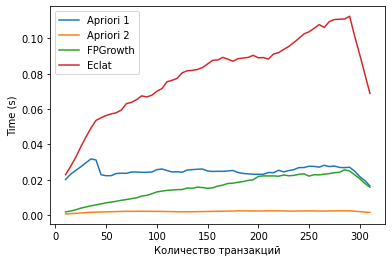

In [76]:
plt.plot(x, smooth(y_apr1, 10), label = "Apriori 1")
plt.plot(x, smooth(y_apr2, 10), label = "Apriori 2")
plt.plot(x, smooth(y_fpg, 10), label = "FPGrowth")
plt.plot(x, smooth(y_ecl, 10), label = "Eclat")
plt.ylabel("Time (s)")
plt.xlabel("Количество транзакций")
plt.legend()
plt.show()

In [84]:
y_apr1 = []
y_apr2 = []
y_fpg = []
y_ecl = []
x = []
transactions_n = [10, 100, 180]

In [ ]:
for n in transactions_n:
  x.append(n)
  y_apr1.append(apriori1(n))

  y_apr2.append(apriori2(n))

  y_fpg.append(fpgrowth(n))

  y_ecl.append(eclat(n))

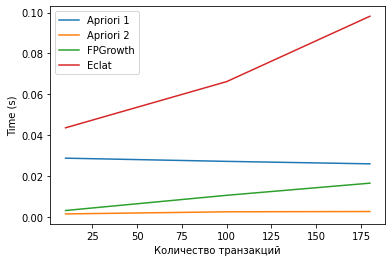

In [86]:
plt.plot(x, y_apr1, label = "Apriori 1")
plt.plot(x, y_apr2, label = "Apriori 2")
plt.plot(x, y_fpg, label = "FPGrowth")
plt.plot(x, y_ecl, label = "Eclat")
plt.ylabel("Time (s)")
plt.xlabel("Количество транзакций")
plt.legend()
plt.show()

##Выводы

* Можно заметить, что FPGrowth для небольших и средних наборов данных работает 
быстрее, чем Apriori с реалиацией из mlxtend. Также скорость работы алгоритма FPGrowth не стремительно увеличивается при увеличении количества транзакций.</br>
* ECLAT на даном датасете работает хуже других алгоритмов. Можно заметить, что он лучше работает на маленьких и средних датасетах, и когда число транзакций становится больше 100 время работы алгоритма начинает стремительнее увеличиваться.</br>
* Можно заметить, что Apriori лучше работает при большем количестве транзакций.</br>
* Реализация Apriori из apyori работает эффективнее, чем из mlxtend.


#Вывод по датасету

Самым часто встречаемым правилом, которое выявили все алгоритмы, оказалось: большой набор продуктов + вино. Также большой набор продуктов + хлеб|молоко|сыр|яйца. Люди часто покупают сыр, яйца, молоко, хлеб вместе.

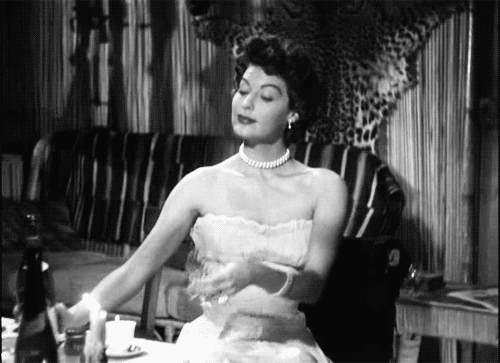